# Are the current highest paying actresses’ movies passing the Bechdel Test?

We are using Forbes' Highest Paid Actress list from 2017 for this analysis. 
https://www.forbes.com/pictures/598b86c731358e60d775bca6/worlds-highest-paid-actre/#6643d43e60b0 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# bringing data for Bechdel Test Ratings
bechdel = pd.read_csv('../Data/bechdel_test_data/bechdel_test_updated.csv', index_col=False)
cols = ['bechdel_id', 'tconst', 'rating', 'title', 'release_yr']
bechdel.columns = cols
bechdel.set_index('tconst', inplace=True)

bechdel.head()

,bechdel_id,rating,title,release_yr
tconst,,,,
tt0000003,5433,0,Pauvre Pierrot,1892
tt0000012,6199,0,"Arrival of a Train, The",1896
tt0000014,5444,0,Tables Turned on the Gardener,1895
tt0000091,4982,0,"House of the Devil, The",1896
tt0000131,5406,0,Une nuit terrible,1896


In order to get all the actresses' films from the IMDB, two tables needed to be joined: title.principals and name.basics. Because of the volume of title.principals (over 29 million rows), we did this first in SQL and exported it to FHPA_all_movies.csv.

In [2]:
movies = pd.read_csv('../Data/FHPA_all_movies.csv', index_col=False)
movies.set_index('tconst', inplace=True)

# removing unnecessary columns
movies.drop(columns=['ordering','category', 'job', 'originaltitle', 'is_adult', 'end_yr'], inplace=True)
movies.head()

# this only contains actresses via imdb name id (nconst)

,nconst,char_played,titletype,primarytitle,start_yr,runtimeminutes,genres
tconst,,,,,,,
tt1758692,nm2225369,"[""Sam""]",movie,Like Crazy,2011.0,86.0,"Drama,Romance"
tt6098920,nm0000210,NaN,movie,Framed,NaN,NaN,Drama
tt0467110,nm0010736,"[""Polly""]",movie,Underdog,2007.0,84.0,"Action,Adventure,Comedy"
tt1156398,nm1297015,"[""Wichita""]",movie,Zombieland,2009.0,88.0,"Adventure,Comedy,Horror"
tt3195742,nm0000949,"[""Narrator""]",movie,Journey to the South Pacific,2013.0,40.0,Documentary


We'll start by joining the Bechdel Test data with the Highest Paid Actresses' movie data on the tconst ID.

In [3]:
movies_w_bechdel = movies.join(bechdel)
movies_w_bechdel.set_index('nconst', inplace=True)

movies_w_bechdel.head()

,char_played,titletype,primarytitle,start_yr,runtimeminutes,genres,bechdel_id,rating,title,release_yr
nconst,,,,,,,,,,
nm0000210,"[""Daisy""]",movie,Mystic Pizza,1988.0,104.0,"Comedy,Drama,Romance",940.0,3.0,Mystic Pizza,1988.0
nm0000210,"[""Shelby Eatenton Latcherie""]",movie,Steel Magnolias,1989.0,117.0,"Comedy,Drama,Romance",924.0,3.0,Steel Magnolias,1989.0
nm0000098,"[""Ava Schector""]",tvMovie,Camp Cucamonga,1990.0,93.0,"Action,Adventure,Comedy",NaN,NaN,NaN,NaN
nm0000210,"[""Dr. Rachel Mannus""]",movie,Flatliners,1990.0,115.0,"Drama,Horror,Sci-Fi",2942.0,3.0,Flatliners,1990.0
nm0000210,"[""Vivian Ward""]",movie,Pretty Woman,1990.0,119.0,"Comedy,Romance",2156.0,3.0,Pretty Woman,1990.0


Some movies will not have a Bechdel Test rating. Let's see how many do have ratings.

In [4]:
# number of ratings we have
print('# of movies with Bechdel Test ratings:', movies_w_bechdel['rating'].count())
print('Total movies from Highest Paid Actresses:', movies_w_bechdel['primarytitle'].count())
print('{0:,.2%}'.format(movies_w_bechdel['rating'].count() / movies_w_bechdel['primarytitle'].count()))

# of movies with Bechdel Test ratings: 176
Total movies from Highest Paid Actresses: 376
46.81%


Unfortunately, a little less than half of these movies have ratings. This is good to know because it will affect our analysis.

But let's get the data on the Highest Paid Actresses...

In [5]:
actresses = pd.read_csv('../Data/Forbes_Highest_Paid_Actresses_2017.csv', index_col=False)
actresses.set_index('primaryname', inplace=True)
actresses.sort_values(by='Rank')
actresses

,Rank,Salary_Millions
primaryname,,
Emma Stone,1,$26
Jennifer Aniston,2,$25.50
Jennifer Lawrence,3,$24
Melissa McCarthy,4,$18
Mila Kunis,5,$15.50
Emma Watson,6,$14
Charlize Theron,7,$14
Cate Blanchett,8,$12
Julia Roberts,9,$12


The Forbes list doesn't contain nconst IDs for us to use as lookups, so we'll have to try to match based on the primaryname column with the name column in the IMDB name.basics table. This process can be messy if the actress doesn't have the exact same name in both titles. If that's the case, we may have to manually look up the actress on the IMDB website.

The names table we're loading in has previously been filtered in SQL for just actors and actresses. 

In [6]:
names = pd.read_csv('../Data/names_filtered.csv', index_col=False)
names.set_index('primaryname', inplace=True)
names.head()

,nconst,birthyear,deathyear,primaryprofession,knownfortitles
primaryname,,,,,
Fred Astaire,nm0000001,1899.0,1987.0,"soundtrack,actor,miscellaneous","tt0043044,tt0072308,tt0050419,tt0045537"
Lauren Bacall,nm0000002,1924.0,2014.0,"actress,soundtrack","tt0071877,tt0117057,tt0037382,tt0038355"
Brigitte Bardot,nm0000003,1934.0,NaN,"actress,soundtrack,producer","tt0059956,tt0057345,tt0054452,tt0049189"
John Belushi,nm0000004,1949.0,1982.0,"actor,writer,soundtrack","tt0080455,tt0078723,tt0072562,tt0077975"
Ingrid Bergman,nm0000006,1915.0,1982.0,"actress,soundtrack,producer","tt0034583,tt0038109,tt0038787,tt0071877"


In [7]:
actresses_w_id = actresses.join(names)
actresses_w_id['primaryname'] = actresses_w_id.index
actresses_w_id.set_index('nconst', inplace=True)
actresses_w_id.sort_values(by='Rank')

,Rank,Salary_Millions,birthyear,deathyear,primaryprofession,knownfortitles,primaryname
nconst,,,,,,,
nm1297015,1,$26,1988.0,NaN,"actress,soundtrack,producer","tt2562232,tt1454029,tt1282140,tt3783958",Emma Stone
nm0000098,2,$25.50,1969.0,NaN,"actress,producer,soundtrack","tt1038919,tt0108778,tt3442006,tt1723121",Jennifer Aniston
nm2225369,3,$24,1990.0,NaN,"actress,soundtrack,producer","tt1270798,tt1800241,tt1392170,tt1045658",Jennifer Lawrence
nm0565250,4,$18,1970.0,NaN,"actress,producer,soundtrack","tt2103254,tt2404463,tt3079380,tt1478338",Melissa McCarthy
nm0005109,5,$15.50,1983.0,NaN,"actress,producer,soundtrack","tt1617661,tt0800039,tt0947798,tt4651520",Mila Kunis
nm0914612,6,$14,1990.0,NaN,"actress,soundtrack,producer","tt0241527,tt2771200,tt1659337,tt2132285",Emma Watson
nm0000234,7,$14,1975.0,NaN,"actress,producer,soundtrack","tt1392190,tt0340855,tt2406566,tt1735898",Charlize Theron
nm0000949,8,$12,1969.0,NaN,"actress,producer,director","tt2334873,tt2402927,tt0338751,tt0127536",Cate Blanchett
nm0000210,9,$12,1967.0,NaN,"actress,producer,soundtrack","tt0100405,tt0119738,tt1322269,tt0195685",Julia Roberts


Our join resulted in 10 rows indicating that we were able to successfully match with primaryname.

Now, let's combine this with the previous dataframe with the Bechdel Test and movie data.

In [8]:
# doesn't account for missing ratings
fhpa_movies_nan = movies_w_bechdel.join(actresses_w_id)

grouped_fhpa_movies_nan = fhpa_movies_nan.groupby(['Rank','primaryname', 'rating'])['primarytitle'].count()
df_group_1 = grouped_fhpa_movies_nan.to_frame()
df_group_1.rename(columns = {'primarytitle': 'movie_count'}, inplace = True)

df_group_1

movie_count
Rank primaryname       rating             
1    Emma Stone        1.0               2
                       2.0               2
                       3.0              10
2    Jennifer Aniston  0.0               1
                       1.0               3
                       2.0               3
                       3.0              14
3    Jennifer Lawrence 0.0               1
                       2.0               1
                       3.0              13
4    Melissa McCarthy  2.0               1
                       3.0               8
5    Mila Kunis        2.0               1
                       3.0               9
6    Emma Watson       1.0               1
                       3.0              14
7    Charlize Theron   0.0               1
                       1.0               3
                       2.0               1
                       3.0              16
8    Cate Blanchett    0.0               1
                       1.0               7
                       2.0               1
                       3.0              18
9    Julia Roberts     1.0               2
                       2.0               7
                       3.0              18
10   Amy Adams         1.0               2
                       2.0               3
                       3.0              12

In [9]:
# doesn't account for missing ratings
df_group_1['percentage'] = df_group_1.movie_count / df_group_1.reset_index().groupby('Rank')['movie_count'].sum()
df_group_1format = df_group_1.style.format({'percentage': '{0:,.2%}'.format})
df_group_1format

In [10]:
# gettting their earliest film release
group2 = fhpa_movies_nan.groupby(['Rank','primaryname'])['release_yr'].min()
group2

Rank  primaryname      
1     Emma Stone           2008.0
2     Jennifer Aniston     1997.0
3     Jennifer Lawrence    2010.0
4     Melissa McCarthy     2008.0
5     Mila Kunis           2008.0
6     Emma Watson          2002.0
7     Charlize Theron      1996.0
8     Cate Blanchett       1997.0
9     Julia Roberts        1988.0
10    Amy Adams            2005.0
Name: release_yr, dtype: float64

In [11]:
fhpa_movies = movies_w_bechdel.join(actresses_w_id)

# Filling the NaN values so later when we do groupby rating, we can see how many movies are missing ratings
# Otherwise the NaN values are excluded from the groupby
fhpa_movies['rating'] = fhpa_movies['rating'].fillna(value='None')

fhpa_movies.head()

,char_played,titletype,primarytitle,start_yr,runtimeminutes,genres,bechdel_id,rating,title,release_yr,Rank,Salary_Millions,birthyear,deathyear,primaryprofession,knownfortitles,primaryname
nconst,,,,,,,,,,,,,,,,,
nm0000098,"[""Ava Schector""]",tvMovie,Camp Cucamonga,1990.0,93.0,"Action,Adventure,Comedy",NaN,None,NaN,NaN,2,$25.50,1969.0,NaN,"actress,producer,soundtrack","tt1038919,tt0108778,tt3442006,tt1723121",Jennifer Aniston
nm0000098,"[""Tory Reding""]",movie,Leprechaun,1993.0,92.0,"Comedy,Fantasy,Horror",NaN,None,NaN,NaN,2,$25.50,1969.0,NaN,"actress,producer,soundtrack","tt1038919,tt0108778,tt3442006,tt1723121",Jennifer Aniston
nm0000098,"[""Herself""]",tvMovie,Sunday Funnies,1993.0,NaN,NaN,NaN,None,NaN,NaN,2,$25.50,1969.0,NaN,"actress,producer,soundtrack","tt1038919,tt0108778,tt3442006,tt1723121",Jennifer Aniston
nm0000098,"[""Allison""]",movie,Dream for an Insomniac,1996.0,90.0,"Comedy,Drama,Romance",NaN,None,NaN,NaN,2,$25.50,1969.0,NaN,"actress,producer,soundtrack","tt1038919,tt0108778,tt3442006,tt1723121",Jennifer Aniston
nm0000098,"[""Renee""]",movie,She's the One,1996.0,96.0,"Comedy,Drama,Romance",NaN,None,NaN,NaN,2,$25.50,1969.0,NaN,"actress,producer,soundtrack","tt1038919,tt0108778,tt3442006,tt1723121",Jennifer Aniston


In [9]:
grouped_fhpa_movies = fhpa_movies.groupby(['Rank','primaryname', 'rating'])['primarytitle'].count()
df_group = grouped_fhpa_movies.to_frame()
df_group.rename(columns = {'primarytitle': 'movie_count'}, inplace = True)

df_group

movie_count
Rank primaryname       rating             
1    Emma Stone        1.0               2
                       2.0               2
                       3.0              10
                       None             13
2    Jennifer Aniston  0.0               1
                       1.0               3
                       2.0               3
                       3.0              14
                       None             39
3    Jennifer Lawrence 0.0               1
                       2.0               1
                       3.0              13
                       None             12
4    Melissa McCarthy  2.0               1
                       3.0               8
                       None              9
5    Mila Kunis        2.0               1
                       3.0               9
                       None             17
6    Emma Watson       1.0               1
                       3.0              14
                       None              5
7    Charlize Theron   0.0               1
                       1.0               3
                       2.0               1
                       3.0              16
                       None             25
8    Cate Blanchett    0.0               1
                       1.0               7
                       2.0               1
                       3.0              18
                       None             31
9    Julia Roberts     1.0               2
                       2.0               7
                       3.0              18
                       None             28
10   Amy Adams         1.0               2
                       2.0               3
                       3.0              12
                       None             21

As expected, many actresses' films do not have ratings, so it's difficult to draw a conclusion from this analysis. The dataframe below also shows the percentage breakdown.

In [10]:
df_group['percentage'] = df_group.movie_count / df_group.reset_index().groupby('Rank')['movie_count'].sum()
df_group_format = df_group.style.format({'percentage': '{0:,.2%}'.format})
df_group_format

In [11]:
# prepping for stacked bar chart
df_group_c = fhpa_movies.groupby(['Rank','primaryname', 'rating'])['primarytitle'].count().unstack('rating')

df_group_c

,rating,0.0,1.0,2.0,3.0,None
Rank,primaryname,,,,,
1,Emma Stone,NaN,2.0,2.0,10.0,13.0
2,Jennifer Aniston,1.0,3.0,3.0,14.0,39.0
3,Jennifer Lawrence,1.0,NaN,1.0,13.0,12.0
4,Melissa McCarthy,NaN,NaN,1.0,8.0,9.0
5,Mila Kunis,NaN,NaN,1.0,9.0,17.0
6,Emma Watson,NaN,1.0,NaN,14.0,5.0
7,Charlize Theron,1.0,3.0,1.0,16.0,25.0
8,Cate Blanchett,1.0,7.0,1.0,18.0,31.0
9,Julia Roberts,NaN,2.0,7.0,18.0,28.0


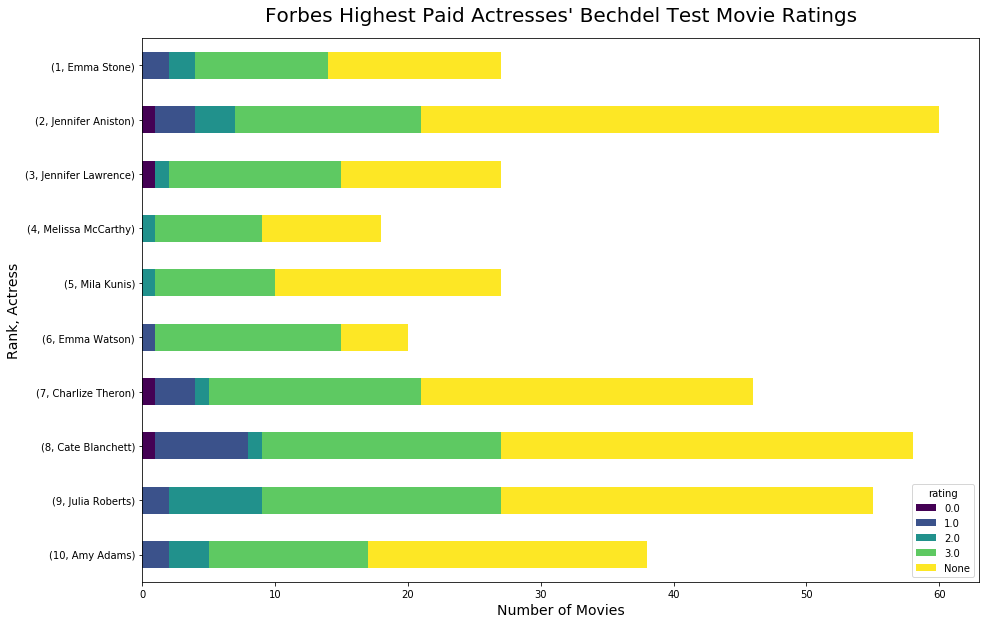

In [12]:
# to reverse the order for horizontal bar chart
df_group_c = df_group_c.iloc[::-1]

chart = df_group_c.plot(kind='barh', stacked=True, figsize=(15,10), colormap='viridis')
chart.set_ylabel('Rank, Actress', size=14)
chart.set_xlabel('Number of Movies', size=14)
chart.set_title("Forbes Highest Paid Actresses' Bechdel Test Movie Ratings", size=20)

# moving the title up a bit
ttl = chart.title
ttl.set_position([0.5, 1.02])

In [13]:
fig = chart.get_figure()
fig.savefig('fhpa_bt_ratings.png', bbox_inches='tight')

In [12]:
# prepping for stacked bar chart
df_group_c2 = fhpa_movies_nan.groupby(['Rank','primaryname', 'rating'])['primarytitle'].count().unstack('rating')

df_group_c2

,rating,0.0,1.0,2.0,3.0
Rank,primaryname,,,,
1,Emma Stone,NaN,2.0,2.0,10.0
2,Jennifer Aniston,1.0,3.0,3.0,14.0
3,Jennifer Lawrence,1.0,NaN,1.0,13.0
4,Melissa McCarthy,NaN,NaN,1.0,8.0
5,Mila Kunis,NaN,NaN,1.0,9.0
6,Emma Watson,NaN,1.0,NaN,14.0
7,Charlize Theron,1.0,3.0,1.0,16.0
8,Cate Blanchett,1.0,7.0,1.0,18.0
9,Julia Roberts,NaN,2.0,7.0,18.0


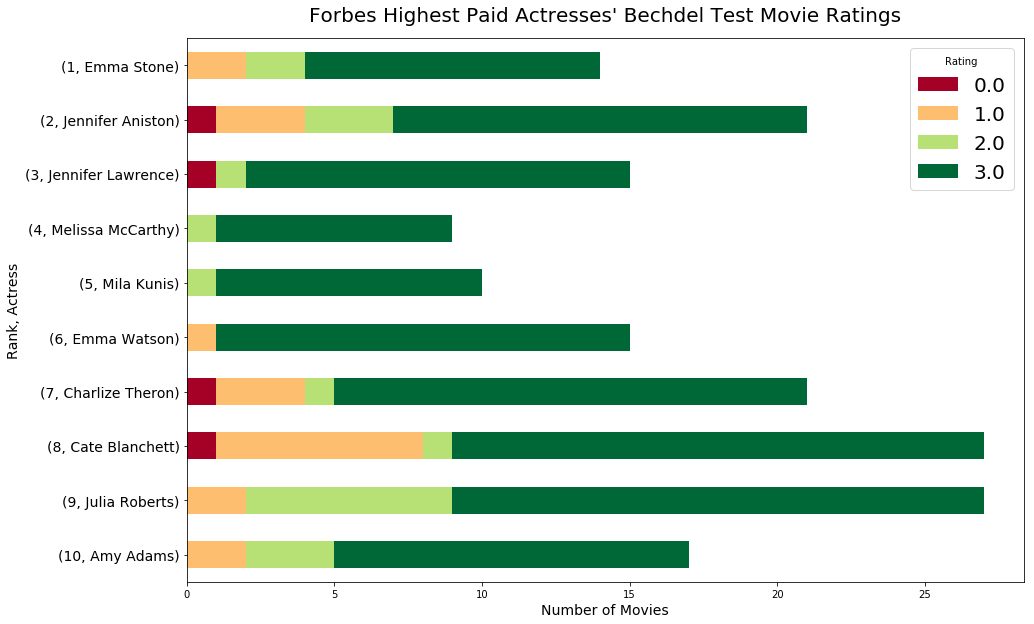

In [15]:
# to reverse the order for horizontal bar chart
df_group_c2 = df_group_c2.iloc[::-1]

chart = df_group_c2.plot(kind='barh', stacked=True, figsize=(15,10), colormap='RdYlGn')
chart.set_ylabel('Rank, Actress', size=14)
chart.set_xlabel('Number of Movies', size=14)
chart.set_title("Forbes Highest Paid Actresses' Bechdel Test Movie Ratings", size=20)

plt.legend(loc=1, prop={'size': 20}, title='Rating')
chart.tick_params(axis='y', labelsize=14)

# moving the title up a bit
ttl = chart.title
ttl.set_position([0.5, 1.02])

In [16]:
fig = chart.get_figure()
fig.savefig('fhpa_bt_ratings2.png', bbox_inches='tight')

Since a large amount of the actresses' movies did not have Bechdel Test ratings, we'll also look to see how their well known movies do in terms of ratings. Given that the Bechdel Test ratings come from user input, we expect that most of their well known movies will have ratings. 

For well known movies, we'll use the knownfortitles column from names.basic. It's unclear how IMDB determined the actresses' well known movies.

In [29]:
pop_titles = actresses_w_id[['primaryname', 'knownfortitles']]
act_list = pop_titles['primaryname'].tolist()
title_list = pop_titles['knownfortitles'].tolist()

print(act_list)
print(title_list)

['Amy Adams', 'Cate Blanchett', 'Charlize Theron', 'Emma Stone', 'Emma Watson', 'Jennifer Aniston', 'Jennifer Lawrence', 'Julia Roberts', 'Melissa McCarthy', 'Mila Kunis']
['tt0918927,tt0461770,tt2543164,tt1800241', 'tt2334873,tt2402927,tt0338751,tt0127536', 'tt1392190,tt0340855,tt2406566,tt1735898', 'tt2562232,tt1454029,tt1282140,tt3783958', 'tt0241527,tt2771200,tt1659337,tt2132285', 'tt1038919,tt0108778,tt3442006,tt1723121', 'tt1270798,tt1800241,tt1392170,tt1045658', 'tt0100405,tt0119738,tt1322269,tt0195685', 'tt2103254,tt2404463,tt3079380,tt1478338', 'tt1617661,tt0800039,tt0947798,tt4651520']


In [30]:
new_title_list = []

for item in title_list:
    new_title_list.append(item.split(','))

print(new_title_list)

[['tt0918927', 'tt0461770', 'tt2543164', 'tt1800241'], ['tt2334873', 'tt2402927', 'tt0338751', 'tt0127536'], ['tt1392190', 'tt0340855', 'tt2406566', 'tt1735898'], ['tt2562232', 'tt1454029', 'tt1282140', 'tt3783958'], ['tt0241527', 'tt2771200', 'tt1659337', 'tt2132285'], ['tt1038919', 'tt0108778', 'tt3442006', 'tt1723121'], ['tt1270798', 'tt1800241', 'tt1392170', 'tt1045658'], ['tt0100405', 'tt0119738', 'tt1322269', 'tt0195685'], ['tt2103254', 'tt2404463', 'tt3079380', 'tt1478338'], ['tt1617661', 'tt0800039', 'tt0947798', 'tt4651520']]


In [32]:
pop_list = []

index = 0

for act in act_list:
    #row = []
    for item in new_title_list[index]:
        pop_list.append([act, item])
    index += 1

pop_list

[['Amy Adams', 'tt0918927'],
 ['Amy Adams', 'tt0461770'],
 ['Amy Adams', 'tt2543164'],
 ['Amy Adams', 'tt1800241'],
 ['Cate Blanchett', 'tt2334873'],
 ['Cate Blanchett', 'tt2402927'],
 ['Cate Blanchett', 'tt0338751'],
 ['Cate Blanchett', 'tt0127536'],
 ['Charlize Theron', 'tt1392190'],
 ['Charlize Theron', 'tt0340855'],
 ['Charlize Theron', 'tt2406566'],
 ['Charlize Theron', 'tt1735898'],
 ['Emma Stone', 'tt2562232'],
 ['Emma Stone', 'tt1454029'],
 ['Emma Stone', 'tt1282140'],
 ['Emma Stone', 'tt3783958'],
 ['Emma Watson', 'tt0241527'],
 ['Emma Watson', 'tt2771200'],
 ['Emma Watson', 'tt1659337'],
 ['Emma Watson', 'tt2132285'],
 ['Jennifer Aniston', 'tt1038919'],
 ['Jennifer Aniston', 'tt0108778'],
 ['Jennifer Aniston', 'tt3442006'],
 ['Jennifer Aniston', 'tt1723121'],
 ['Jennifer Lawrence', 'tt1270798'],
 ['Jennifer Lawrence', 'tt1800241'],
 ['Jennifer Lawrence', 'tt1392170'],
 ['Jennifer Lawrence', 'tt1045658'],
 ['Julia Roberts', 'tt0100405'],
 ['Julia Roberts', 'tt0119738'],
 ['Jul

In [46]:
df_list = pd.DataFrame(pop_list)
cols = ['primaryname', 'tconst']
df_list.columns = cols
df_list.set_index('tconst', inplace=True)
df_list

,primaryname
tconst,
tt0918927,Amy Adams
tt0461770,Amy Adams
tt2543164,Amy Adams
tt1800241,Amy Adams
tt2334873,Cate Blanchett
tt2402927,Cate Blanchett
tt0338751,Cate Blanchett
tt0127536,Cate Blanchett
tt1392190,Charlize Theron


In [47]:
pop_title_bechdel = df_list.join(bechdel)
pop_title_bechdel

,primaryname,bechdel_id,rating,title,release_yr
tconst,,,,,
tt0100405,Julia Roberts,2156.0,3.0,Pretty Woman,1990.0
tt0108778,Jennifer Aniston,NaN,NaN,NaN,NaN
tt0119738,Julia Roberts,1202.0,2.0,My Best Friend&#39;s Wedding,1997.0
tt0127536,Cate Blanchett,2138.0,3.0,Elizabeth,1998.0
tt0195685,Julia Roberts,452.0,3.0,Erin Brockovich,2000.0
tt0241527,Emma Watson,1781.0,3.0,Harry Potter and the Sorcerer&#39;s Stone,2001.0
tt0338751,Cate Blanchett,3261.0,1.0,"Aviator, The",2004.0
tt0340855,Charlize Theron,271.0,3.0,Monster,2003.0
tt0461770,Amy Adams,777.0,3.0,Enchanted,2007.0


In [48]:
df_pop_title = pop_title_bechdel.groupby(['primaryname', 'rating']).count()
df_pop_title

bechdel_id  title  release_yr
primaryname       rating                               
Amy Adams         3.0              4      4           4
Cate Blanchett    1.0              1      1           1
                  3.0              3      3           3
Charlize Theron   3.0              4      4           4
Emma Stone        3.0              4      4           4
Emma Watson       3.0              4      4           4
Jennifer Aniston  3.0              2      2           2
Jennifer Lawrence 3.0              4      4           4
Julia Roberts     2.0              1      1           1
                  3.0              3      3           3
Melissa McCarthy  3.0              4      4           4
Mila Kunis        3.0              4      4           4

In [51]:
fhpa_movies_nan[fhpa_movies_nan['rating'] == 0]

,char_played,titletype,primarytitle,start_yr,runtimeminutes,genres,bechdel_id,rating,title,release_yr,Rank,Salary_Millions,birthyear,deathyear,primaryprofession,knownfortitles,primaryname
nconst,,,,,,,,,,,,,,,,,
nm0000098,"[""Annie Hughes""]",movie,The Iron Giant,1999.0,86.0,"Action,Adventure,Animation",884.0,0.0,"Iron Giant, The",1999.0,2,$25.50,1969.0,NaN,"actress,producer,soundtrack","tt1038919,tt0108778,tt3442006,tt1723121",Jennifer Aniston
nm0000234,"[""Mary""]",movie,Hancock,2008.0,92.0,"Action,Crime,Drama",61.0,0.0,Hancock,2008.0,7,$14,1975.0,NaN,"actress,producer,soundtrack","tt1392190,tt0340855,tt2406566,tt1735898",Charlize Theron
nm0000949,"[""Claire Simone""]",movie,The Monuments Men,2014.0,118.0,"Drama,History,War",5144.0,0.0,"Monuments Men, The",2014.0,8,$12,1969.0,NaN,"actress,producer,director","tt2334873,tt2402927,tt0338751,tt0127536",Cate Blanchett
nm2225369,"[""Aurora Lane""]",movie,Passengers,2016.0,116.0,"Drama,Romance,Sci-Fi",7356.0,0.0,Passengers,2016.0,3,$24,1990.0,NaN,"actress,soundtrack,producer","tt1270798,tt1800241,tt1392170,tt1045658",Jennifer Lawrence


In [52]:
fhpa_movies_nan.groupby(['rating']).count()

,char_played,titletype,primarytitle,start_yr,runtimeminutes,genres,bechdel_id,title,release_yr,Rank,Salary_Millions,birthyear,deathyear,primaryprofession,knownfortitles,primaryname
rating,,,,,,,,,,,,,,,,
0.0,4,4,4,4,4,4,4,4,4,4,4,4,0,4,4,4
1.0,20,20,20,20,20,20,20,20,20,20,20,20,0,20,20,20
2.0,20,20,20,20,20,20,20,20,20,20,20,20,0,20,20,20
3.0,132,132,132,132,132,132,132,132,132,132,132,132,0,132,132,132
